In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from sklearn.model_selection import train_test_split
import lightgbm as lgb

/var/folders/_v/78p688311b1406y84pvwbn4c0000gp/T/ipykernel_69711/2850567124.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
df_train = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/train.csv")
target_train = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/target_train.csv")
df_test = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/test.csv")
sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv")

df_train_with_target = df_train.merge(target_train,on="ID")

df_all = pd.concat([df_train,df_test])

df_all_with_target = df_all.merge(target_train,how="left",on="ID")

In [139]:
df_all_with_target

,ID,dt_close,product_id,liquidity_rank,normal_trading_day,dt_expiry,open,high,low,close,open_interest,volume,tick_size,fixed,spread
0,0,8862,401920,0,1,8952,2710.0,2721.0,2624.0,2635.0,2814,402,11,0,2.552161
1,1,8862,401920,1,1,8995,2610.0,2638.0,2547.0,2560.0,905,107,11,0,3.575163
2,2,8862,401920,2,1,9039,2530.0,2550.0,2468.0,2478.0,719,41,11,0,5.351175
3,3,8862,401920,3,1,9104,2497.0,2508.0,2437.0,2443.0,466,25,11,0,5.285281
4,4,8862,401920,4,1,9213,2474.0,2505.0,2443.0,2452.0,286,11,11,0,9.712062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859910,858592,11448,198575104,2,1,11635,19860.0,19860.0,19851.0,19852.0,761,116,10,0,NaN
859911,858593,11448,198575104,3,1,11705,19820.0,19820.0,19808.0,19809.0,782,135,10,0,NaN
859912,858594,11448,198575104,4,1,11770,19781.0,19781.0,19765.0,19767.0,696,159,10,0,NaN
859913,858595,11448,198575104,5,1,11830,19741.0,19741.0,19726.0,19727.0,565,108,10,0,NaN


In [3]:
df_all_with_target_fe = df_all_with_target.copy()

df_all_with_target_fe["expiry"] = df_all_with_target_fe["dt_expiry"] - df_all_with_target_fe["dt_close"]
df_all_with_target_fe["diff_high_low"] = df_all_with_target_fe["high"] - df_all_with_target_fe["low"]
df_all_with_target_fe["diff_close_open"] = df_all_with_target_fe["close"] - df_all_with_target_fe["open"]

df_all_with_target_fe["diff_high_low_angle_cos"] = df_all_with_target_fe["diff_high_low"] / (df_all_with_target_fe["diff_high_low"] ** 2 + 1)
df_all_with_target_fe["diff_close_open_angle_cos"] = df_all_with_target_fe["diff_close_open"] / (df_all_with_target_fe["diff_close_open"] ** 2 + 1)

df_all_with_target_fe["diff_high_low_angle_sin"] = 1 / (df_all_with_target_fe["diff_high_low"] ** 2 + 1)
df_all_with_target_fe["diff_close_open_angle_sin"] = 1 / (df_all_with_target_fe["diff_close_open"] ** 2 + 1)

df_all_with_target_fe["percent_high_low"] = df_all_with_target_fe["diff_high_low"] / df_all_with_target_fe["open"]
df_all_with_target_fe["percent_close_open"] = df_all_with_target_fe["diff_close_open"] / df_all_with_target_fe["open"]

In [4]:
periods = [3, 5, 10, 15, 25, 50, 100]
global_cols = ["volume","diff_high_low","diff_close_open","percent_close_open","percent_high_low","diff_high_low_angle_cos","diff_close_open_angle_cos","diff_high_low_angle_sin","diff_close_open_angle_sin"]
ls_global_fe = []
for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank].sort_values("dt_close")
        ls_mask_fe_unit = []
        for col in global_cols:
            for p in periods:
                roll_mean = df_pid_rank[col].rolling(p, min_periods=1,center=True).mean().rename(f"{col}_mean_{p}")
                roll_std = df_pid_rank[col].rolling(p, min_periods=1,center=True).std().rename(f"{col}_std_{p}")
                ls_mask_fe_unit.append(roll_mean)
                ls_mask_fe_unit.append(roll_std)                
        ls_global_fe.append(ls_mask_fe_unit)
df_global_fe = pd.concat(pd.concat(unit_ex,axis=1) for unit_ex in ls_global_fe)
df_all_with_target_fe = pd.concat([df_all_with_target_fe, df_global_fe],axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:12<00:00,  8.15it/s]


In [5]:
df_all_with_target_fe

,ID,dt_close,product_id,liquidity_rank,normal_trading_day,dt_expiry,open,high,low,close,...,diff_close_open_angle_sin_mean_10,diff_close_open_angle_sin_std_10,diff_close_open_angle_sin_mean_15,diff_close_open_angle_sin_std_15,diff_close_open_angle_sin_mean_25,diff_close_open_angle_sin_std_25,diff_close_open_angle_sin_mean_50,diff_close_open_angle_sin_std_50,diff_close_open_angle_sin_mean_100,diff_close_open_angle_sin_std_100
0,0,8862,401920,0,1,8952,2710.0,2721.0,2624.0,2635.0,...,0.001260,0.001800,0.002865,0.004085,0.002875,0.004337,0.006742,0.019810,0.022173,0.076953
1,1,8862,401920,1,1,8995,2610.0,2638.0,2547.0,2560.0,...,0.100336,0.223419,0.064087,0.176148,0.055073,0.144519,0.033382,0.105522,0.031890,0.084495
2,2,8862,401920,2,1,9039,2530.0,2550.0,2468.0,2478.0,...,0.004779,0.005235,0.004530,0.004400,0.005069,0.005422,0.008595,0.020042,0.057253,0.180825
3,3,8862,401920,3,1,9104,2497.0,2508.0,2437.0,2443.0,...,0.013507,0.025396,0.010568,0.019860,0.025194,0.055447,0.034235,0.105273,0.033047,0.101555
4,4,8862,401920,4,1,9213,2474.0,2505.0,2443.0,2452.0,...,0.017839,0.023766,0.012803,0.019430,0.090896,0.273786,0.109359,0.285684,0.066783,0.208172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859910,858592,11448,198575104,2,1,11635,19860.0,19860.0,19851.0,19852.0,...,0.135734,0.148544,0.126347,0.136423,0.189186,0.239509,0.413872,0.368013,0.496888,0.367476
859911,858593,11448,198575104,3,1,11705,19820.0,19820.0,19808.0,19809.0,...,0.158907,0.300777,0.139577,0.275867,0.154926,0.247024,0.279752,0.329576,0.305262,0.331697
859912,858594,11448,198575104,4,1,11770,19781.0,19781.0,19765.0,19767.0,...,0.053260,0.059148,0.052491,0.053708,0.111493,0.157258,0.255716,0.336005,0.233474,0.296111
859913,858595,11448,198575104,5,1,11830,19741.0,19741.0,19726.0,19727.0,...,0.041314,0.034708,0.042535,0.031821,0.092308,0.120274,0.217330,0.271075,0.219139,0.280897


In [6]:
def is_next_period(row, max_ex, min_ex):
    #if row["expiry"] > max_ex * 0.3 and (row["expiry"] - row["last_expiry"]) > (max_ex-min_ex) * 0.3:
    if row["expiry"] - row["last_expiry"] > 0:
        return 1
    else: return 0
    
for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank].sort_values("dt_close")
        df_pid_rank["last_expiry"] = df_pid_rank["expiry"].shift(1)
        max_ex, min_ex = df_pid_rank["expiry"].max(),df_pid_rank["expiry"].min()
        df_pid_rank["num_period"] = df_pid_rank.apply(is_next_period,axis=1, args=(max_ex, min_ex)).cumsum()
        df_all_with_target_fe.loc[df_pid_rank.index,"num_period"] = df_pid_rank["num_period"]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:13<00:00,  7.65it/s]


In [9]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_
                      
dict_agg = {
            "period_high_std" : pd.NamedAgg(column="high", aggfunc=np.std),
            "period_low_std" : pd.NamedAgg(column="low", aggfunc=np.std),
            "period_open_std" : pd.NamedAgg(column="open", aggfunc=np.std),
            "period_close_std" : pd.NamedAgg(column="close", aggfunc=np.std),
            "period_dco_std" : pd.NamedAgg(column="diff_close_open", aggfunc=np.std),
            "period_dhl_std" : pd.NamedAgg(column="diff_high_low", aggfunc=np.std),
    
            "period_high_mean" : pd.NamedAgg(column="high", aggfunc=np.mean),
            "period_low_mean" : pd.NamedAgg(column="low", aggfunc=np.mean),
            "period_open_mean" : pd.NamedAgg(column="open", aggfunc=np.mean),
            "period_close_mean" : pd.NamedAgg(column="close", aggfunc=np.mean),
            "period_dco_mean" : pd.NamedAgg(column="diff_close_open", aggfunc=np.mean),
            "period_dhl_mean" : pd.NamedAgg(column="diff_high_low", aggfunc=np.mean),
    
            "period_diff_high_low_angle_cos_mean" : pd.NamedAgg(column="diff_high_low_angle_cos", aggfunc=np.mean),
            "period_diff_high_low_angle_cos_std" : pd.NamedAgg(column="diff_high_low_angle_cos", aggfunc=np.std),
    
            "period_diff_close_open_angle_cos_mean" : pd.NamedAgg(column="diff_close_open_angle_cos", aggfunc=np.mean),
            "period_diff_close_open_angle_cos_std" : pd.NamedAgg(column="diff_close_open_angle_cos", aggfunc=np.std),
    
            "period_diff_high_low_angle_sin_mean" : pd.NamedAgg(column="diff_high_low_angle_sin", aggfunc=np.mean),
            "period_diff_high_low_angle_sin_std" : pd.NamedAgg(column="diff_high_low_angle_sin", aggfunc=np.std),
    
            "period_diff_close_open_angle_sin_mean" : pd.NamedAgg(column="diff_close_open_angle_sin", aggfunc=np.mean),
            "period_diff_close_open_angle_sin_std" : pd.NamedAgg(column="diff_close_open_angle_sin", aggfunc=np.std),
    

            "period_phl_mean" : pd.NamedAgg(column="percent_high_low", aggfunc=np.mean),
            "period_phl_std" : pd.NamedAgg(column="percent_high_low", aggfunc=np.std),   
            "period_pco_mean" : pd.NamedAgg(column="percent_close_open", aggfunc=np.mean),
            "period_pco_std" : pd.NamedAgg(column="percent_close_open", aggfunc=np.std),   
            "period_interest_mean" : pd.NamedAgg(column="open_interest", aggfunc=np.mean),
            "period_interest_std" : pd.NamedAgg(column="open_interest", aggfunc=np.std), 
            "period_interest_quantile25" : pd.NamedAgg(column="open_interest", aggfunc=percentile(25)),
            "period_interest_quantile75" : pd.NamedAgg(column="open_interest", aggfunc=percentile(75)),
            "period_volume_mean" : pd.NamedAgg(column="volume", aggfunc=np.mean),
            "period_volume_std" : pd.NamedAgg(column="volume", aggfunc=np.std), 
            "period_volume_quantile25" : pd.NamedAgg(column="volume", aggfunc=percentile(25)),
            "period_volume_quantile75" : pd.NamedAgg(column="volume", aggfunc=percentile(75)),
}
for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        period_mean_std = df_pid_rank.groupby("num_period").agg(
                                                            **dict_agg
                                                            )
        df_pid_rank_period_merge = df_pid_rank[["num_period"]].merge(period_mean_std,how="left",left_on="num_period",right_index=True).drop("num_period",axis=1)
        df_all_with_target_fe.loc[df_pid_rank.index,df_pid_rank_period_merge.columns] = df_pid_rank_period_merge

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:22<00:00,  4.56it/s]


In [11]:
dict_rename1 = {"high":"high_diff","low":"low_diff","open":"open_diff","close":"close_diff","diff_close_open":"diff_close_open_diff","diff_high_low":"diff_high_low_diff","volume":"volume_diff"}
dict_rename2 = {"high":"high_diff_angle","low":"low_diff_angle","open":"open_diff_angle","close":"close_diff_angle","diff_close_open":"diff_close_open_diff_angle","diff_high_low":"diff_high_low_diff_angle","volume":"volume_diff_angle"}
dict_rename3 = {"high":"high_diff_angle2","low":"low_diff_angle2","open":"open_diff_angle2","close":"close_diff_angle2","diff_close_open":"diff_close_open_diff_angle2","diff_high_low":"diff_high_low_diff_angle2","volume":"volume_diff_angle2"}

for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        period_diff = df_pid_rank.groupby("num_period")[["high","low","open","close","diff_close_open","diff_high_low","volume"]].diff(1)
        period_diff_1 = period_diff.rename(dict_rename1,axis=1)
        df_all_with_target_fe.loc[period_diff_1.index,period_diff_1.columns] = period_diff_1
        
        period_diff_2 = (period_diff / (period_diff ** 2 + 1)).rename(dict_rename2,axis=1)
        df_all_with_target_fe.loc[period_diff_2.index,period_diff_2.columns] = period_diff_2
        
        period_diff_3 = (1/ (period_diff ** 2 + 1)).rename(dict_rename3,axis=1)
        df_all_with_target_fe.loc[period_diff_3.index,period_diff_3.columns] = period_diff_3
        
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.52it/s]


In [12]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

dict_agg = {
            "period_high_std" : pd.NamedAgg(column="high", aggfunc=np.std),
            "period_low_std" : pd.NamedAgg(column="low", aggfunc=np.std),
            "period_open_std" : pd.NamedAgg(column="open", aggfunc=np.std),
            "period_close_std" : pd.NamedAgg(column="close", aggfunc=np.std),
            "period_dco_std" : pd.NamedAgg(column="diff_close_open", aggfunc=np.std),
            "period_dhl_std" : pd.NamedAgg(column="diff_high_low", aggfunc=np.std),
    
            "period_high_mean" : pd.NamedAgg(column="high", aggfunc=np.mean),
            "period_low_mean" : pd.NamedAgg(column="low", aggfunc=np.mean),
            "period_open_mean" : pd.NamedAgg(column="open", aggfunc=np.mean),
            "period_close_mean" : pd.NamedAgg(column="close", aggfunc=np.mean),
            "period_dco_mean" : pd.NamedAgg(column="diff_close_open", aggfunc=np.mean),
            "period_dhl_mean" : pd.NamedAgg(column="diff_high_low", aggfunc=np.mean),
    
            "period_diff_high_low_angle_cos_mean" : pd.NamedAgg(column="diff_high_low_angle_cos", aggfunc=np.mean),
            "period_diff_high_low_angle_cos_std" : pd.NamedAgg(column="diff_high_low_angle_cos", aggfunc=np.std),
    
            "period_diff_close_open_angle_cos_mean" : pd.NamedAgg(column="diff_close_open_angle_cos", aggfunc=np.mean),
            "period_diff_close_open_angle_cos_std" : pd.NamedAgg(column="diff_close_open_angle_cos", aggfunc=np.std),
    
            "period_diff_high_low_angle_sin_mean" : pd.NamedAgg(column="diff_high_low_angle_sin", aggfunc=np.mean),
            "period_diff_high_low_angle_sin_std" : pd.NamedAgg(column="diff_high_low_angle_sin", aggfunc=np.std),
    
            "period_diff_close_open_angle_sin_mean" : pd.NamedAgg(column="diff_close_open_angle_sin", aggfunc=np.mean),
            "period_diff_close_open_angle_sin_std" : pd.NamedAgg(column="diff_close_open_angle_sin", aggfunc=np.std),
    

            "period_phl_mean" : pd.NamedAgg(column="percent_high_low", aggfunc=np.mean),
            "period_phl_std" : pd.NamedAgg(column="percent_high_low", aggfunc=np.std),   
            "period_pco_mean" : pd.NamedAgg(column="percent_close_open", aggfunc=np.mean),
            "period_pco_std" : pd.NamedAgg(column="percent_close_open", aggfunc=np.std),   
            "period_interest_mean" : pd.NamedAgg(column="open_interest", aggfunc=np.mean),
            "period_interest_std" : pd.NamedAgg(column="open_interest", aggfunc=np.std), 
            "period_interest_quantile25" : pd.NamedAgg(column="open_interest", aggfunc=percentile(25)),
            "period_interest_quantile75" : pd.NamedAgg(column="open_interest", aggfunc=percentile(75)),
            "period_volume_mean" : pd.NamedAgg(column="volume", aggfunc=np.mean),
            "period_volume_std" : pd.NamedAgg(column="volume", aggfunc=np.std), 
            "period_volume_quantile25" : pd.NamedAgg(column="volume", aggfunc=percentile(25)),
            "period_volume_quantile75" : pd.NamedAgg(column="volume", aggfunc=percentile(75)),
}

for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        expiry_mean_std = df_pid_rank.groupby("expiry").agg(**dict_agg)
        df_pid_rank_expiry_merge = df_pid_rank[["expiry"]].merge(expiry_mean_std,how="left",left_on="expiry",right_index=True).drop("expiry",axis=1)
        df_all_with_target_fe.loc[df_pid_rank.index,df_pid_rank_expiry_merge.columns] = df_pid_rank_expiry_merge

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:22<00:00,  4.58it/s]


In [93]:
dict_rename1 = {"high":"e_high_diff","low":"e_low_diff","open":"e_open_diff","close":"e_close_diff","diff_close_open":"e_diff_close_open_diff","diff_high_low":"e_diff_high_low_diff","volume":"e_volume_diff"}
dict_rename2 = {"high":"e_high_diff_angle","low":"e_low_diff_angle","open":"e_open_diff_angle","close":"e_close_diff_angle","diff_close_open":"e_diff_close_open_diff_angle","diff_high_low":"e_diff_high_low_diff_angle","volume":"e_volume_diff_angle"}
dict_rename3 = {"high":"e_high_diff_angle2","low":"e_low_diff_angle2","open":"e_open_diff_angle2","close":"e_close_diff_angle2","diff_close_open":"e_diff_close_open_diff_angle2","diff_high_low":"e_diff_high_low_diff_angle2","volume":"e_volume_diff_angle2"}

for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        period_diff = df_pid_rank.groupby("expiry")[["high","low","open","close","diff_close_open","diff_high_low","volume"]].diff(1)
        period_diff_1 = period_diff.rename(dict_rename1,axis=1)
        df_all_with_target_fe.loc[period_diff_1.index,period_diff_1.columns] = period_diff_1
        
        period_diff_2 = (period_diff / (period_diff ** 2 + 1)).rename(dict_rename2,axis=1)
        df_all_with_target_fe.loc[period_diff_2.index,period_diff_2.columns] = period_diff_2
        
        period_diff_3 = (1/ (period_diff ** 2 + 1)).rename(dict_rename3,axis=1)
        df_all_with_target_fe.loc[period_diff_3.index,period_diff_3.columns] = period_diff_3

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 14.08it/s]


In [95]:
df_learn_clean = pd.read_pickle("df_mask_pid5.pkl")

In [118]:
cols_spread = [col for col in df_learn_clean if col.startswith('spread_')] + [col for col in df_learn_clean if col.startswith('interp')] + [col for col in df_learn_clean if col.endswith('_spread')]
#cols_conserved = cols_spread + list(df_train_with_target.columns)

cols_conserved = cols_spread[:-1] + ["ID"]

In [120]:
df_learn_clean_new = df_learn_clean[cols_conserved].merge(df_all_with_target_fe,on="ID",how="left")

In [138]:
params = {"learning_rate":0.05, 'objective': 'regression','num_leaves': 192, 'max_depth': 8,
    'subsample': 0.8, 
    'colsample_bytree': 0.8,'metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

features = df_learn_clean_new.columns.drop(["ID","spread"])



nfold = 10
val_scores = []
for fold_id in range(nfold):
    print("Fold %d / %d" % (fold_id + 1, nfold))
    id_ti, id_vi = train_test_split(df_learn_clean_new["ID"].unique(),test_size=0.2)
    train_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_ti)].index
    valid_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_vi)].index
    

    train_dataset = lgb.Dataset(df_learn_clean_new.loc[train_idx, features],
                                df_learn_clean_new.loc[train_idx, "spread"].values, 
                                #feature_name = features, 
                               )
    val_dataset = lgb.Dataset(df_learn_clean_new.loc[valid_idx, features], 
                              df_learn_clean_new.loc[valid_idx, "spread"].values, 
                              #feature_name = features, 
                             )
    
    res = {}
    
    gbm = lgb.train(params, train_dataset, num_boost_round=20000, 
                    valid_sets=[train_dataset, val_dataset], valid_names=['tr', 'vl'],
                    categorical_feature=["fixed","normal_trading_day"],
                    evals_result=res, verbose_eval=100)
    
    gbm.save_model('models/all_1512/lightgbm_model_%d.txt' % fold_id)
    
    val_scores.append(res['vl']['rmse'][-1])
print("avg_val_score: %4f" % (np.mean(val_scores)))

Fold 1 / 10


/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.674758	vl's rmse: 0.735762
[200]	tr's rmse: 0.618089	vl's rmse: 0.718334
[300]	tr's rmse: 0.581118	vl's rmse: 0.710439
[400]	tr's rmse: 0.55076	vl's rmse: 0.705328
[500]	tr's rmse: 0.524596	vl's rmse: 0.701502
[600]	tr's rmse: 0.501777	vl's rmse: 0.698803
[700]	tr's rmse: 0.481066	vl's rmse: 0.696077
[800]	tr's rmse: 0.462224	vl's rmse: 0.693716
[900]	tr's rmse: 0.44378	vl's rmse: 0.692003
[1000]	tr's rmse: 0.428742	vl's rmse: 0.690404
[1100]	tr's rmse: 0.413845	vl's rmse: 0.688811
[1200]	tr's rmse: 0.399125	vl's rmse: 0.687314
[1300]	tr's rmse: 0.386215	vl's rmse: 0.686053
[1400]	tr's rmse: 0.373615	vl's rmse: 0.684952
[1500]	tr's rmse: 0.362231	vl's rmse: 0.684034
[1600]	tr's rmse: 0.351556	vl's rmse: 0.683167
[1700]	tr's rmse: 0.341168	vl's rmse: 0.682311
[1800]	tr's rmse: 0.331395	vl's rmse: 0.681567
[1900]	tr's rmse: 0.322822	vl's rmse: 0.680811
[2000]	tr's rmse: 0.314251	vl's rmse: 0.68025
[2100]	tr's

[6300]	tr's rmse: 0.142556	vl's rmse: 0.65672
[6400]	tr's rmse: 0.140624	vl's rmse: 0.656653
[6500]	tr's rmse: 0.138669	vl's rmse: 0.656608
[6600]	tr's rmse: 0.136814	vl's rmse: 0.656535
[6700]	tr's rmse: 0.135095	vl's rmse: 0.656432
[6800]	tr's rmse: 0.133287	vl's rmse: 0.656345
[6900]	tr's rmse: 0.131585	vl's rmse: 0.65627
[7000]	tr's rmse: 0.129912	vl's rmse: 0.656185
[7100]	tr's rmse: 0.128243	vl's rmse: 0.656095
[7200]	tr's rmse: 0.126691	vl's rmse: 0.656023
[7300]	tr's rmse: 0.125149	vl's rmse: 0.655947
[7400]	tr's rmse: 0.123598	vl's rmse: 0.655868
[7500]	tr's rmse: 0.122035	vl's rmse: 0.655792
[7600]	tr's rmse: 0.120535	vl's rmse: 0.655722
[7700]	tr's rmse: 0.119117	vl's rmse: 0.655664
[7800]	tr's rmse: 0.117682	vl's rmse: 0.655639
[7900]	tr's rmse: 0.116359	vl's rmse: 0.655585
[8000]	tr's rmse: 0.114926	vl's rmse: 0.655522
[8100]	tr's rmse: 0.113607	vl's rmse: 0.655469
[8200]	tr's rmse: 0.112273	vl's rmse: 0.655411
[8300]	tr's rmse: 0.11095	vl's rmse: 0.655377
[8400]	tr's rmse

[4600]	tr's rmse: 0.184819	vl's rmse: 0.668277
[4700]	tr's rmse: 0.181859	vl's rmse: 0.668143
[4800]	tr's rmse: 0.178963	vl's rmse: 0.667977
[4900]	tr's rmse: 0.176218	vl's rmse: 0.667834
[5000]	tr's rmse: 0.17337	vl's rmse: 0.667698
[5100]	tr's rmse: 0.17065	vl's rmse: 0.667559
[5200]	tr's rmse: 0.167933	vl's rmse: 0.667454
[5300]	tr's rmse: 0.165151	vl's rmse: 0.667328
[5400]	tr's rmse: 0.162781	vl's rmse: 0.667214
Early stopping, best iteration is:
[5429]	tr's rmse: 0.162096	vl's rmse: 0.667165
Fold 5 / 10
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.67466	vl's rmse: 0.733964
[200]	tr's rmse: 0.620135	vl's rmse: 0.71679
[300]	tr's rmse: 0.582739	vl's rmse: 0.708857
[400]	tr's rmse: 0.551081	vl's rmse: 0.703851
[500]	tr's rmse: 0.523269	vl's rmse: 0.699998
[600]	tr's rmse: 0.498948	vl's rmse: 0.696838
[700]	tr's rmse: 0.477298	vl's rmse: 0.694168
[800]	tr's rmse: 0.458387	vl's rmse: 0.692303
[900]	tr's rmse: 0.440862	vl's rmse: 0.690634
[1000]	tr's 

[4000]	tr's rmse: 0.203805	vl's rmse: 0.671814
[4100]	tr's rmse: 0.200198	vl's rmse: 0.671651
[4200]	tr's rmse: 0.196868	vl's rmse: 0.671493
[4300]	tr's rmse: 0.19347	vl's rmse: 0.671342
[4400]	tr's rmse: 0.190194	vl's rmse: 0.671151
[4500]	tr's rmse: 0.187013	vl's rmse: 0.67101
[4600]	tr's rmse: 0.183918	vl's rmse: 0.670894
[4700]	tr's rmse: 0.181103	vl's rmse: 0.670735
[4800]	tr's rmse: 0.178275	vl's rmse: 0.670593
[4900]	tr's rmse: 0.175529	vl's rmse: 0.670461
[5000]	tr's rmse: 0.172653	vl's rmse: 0.670353
[5100]	tr's rmse: 0.169854	vl's rmse: 0.670237
[5200]	tr's rmse: 0.167145	vl's rmse: 0.670103
[5300]	tr's rmse: 0.164549	vl's rmse: 0.669959
[5400]	tr's rmse: 0.162022	vl's rmse: 0.669827
[5500]	tr's rmse: 0.159547	vl's rmse: 0.669677
[5600]	tr's rmse: 0.157197	vl's rmse: 0.669616
[5700]	tr's rmse: 0.154846	vl's rmse: 0.66951
[5800]	tr's rmse: 0.152757	vl's rmse: 0.669427
[5900]	tr's rmse: 0.150526	vl's rmse: 0.669289
[6000]	tr's rmse: 0.148319	vl's rmse: 0.669203
[6100]	tr's rmse

[900]	tr's rmse: 0.440963	vl's rmse: 0.693645
[1000]	tr's rmse: 0.424915	vl's rmse: 0.691879
[1100]	tr's rmse: 0.410518	vl's rmse: 0.690747
[1200]	tr's rmse: 0.396911	vl's rmse: 0.689513
[1300]	tr's rmse: 0.384684	vl's rmse: 0.688442
[1400]	tr's rmse: 0.372816	vl's rmse: 0.687369
[1500]	tr's rmse: 0.361231	vl's rmse: 0.686569
[1600]	tr's rmse: 0.35085	vl's rmse: 0.685814
[1700]	tr's rmse: 0.341236	vl's rmse: 0.685071
[1800]	tr's rmse: 0.332206	vl's rmse: 0.684206
[1900]	tr's rmse: 0.323704	vl's rmse: 0.683436
[2000]	tr's rmse: 0.314737	vl's rmse: 0.682734
[2100]	tr's rmse: 0.306523	vl's rmse: 0.682017
[2200]	tr's rmse: 0.29918	vl's rmse: 0.68139
[2300]	tr's rmse: 0.291862	vl's rmse: 0.680961
[2400]	tr's rmse: 0.285096	vl's rmse: 0.680577
[2500]	tr's rmse: 0.278422	vl's rmse: 0.680132
[2600]	tr's rmse: 0.27189	vl's rmse: 0.679735
[2700]	tr's rmse: 0.265721	vl's rmse: 0.67927
[2800]	tr's rmse: 0.259951	vl's rmse: 0.678889
[2900]	tr's rmse: 0.254214	vl's rmse: 0.678481
[3000]	tr's rmse: 0

[7200]	tr's rmse: 0.127163	vl's rmse: 0.666294
[7300]	tr's rmse: 0.125615	vl's rmse: 0.666232
[7400]	tr's rmse: 0.124083	vl's rmse: 0.666198
[7500]	tr's rmse: 0.122521	vl's rmse: 0.666152
[7600]	tr's rmse: 0.121001	vl's rmse: 0.666103
[7700]	tr's rmse: 0.11952	vl's rmse: 0.666033
[7800]	tr's rmse: 0.118172	vl's rmse: 0.665978
[7900]	tr's rmse: 0.116707	vl's rmse: 0.665925
[8000]	tr's rmse: 0.11538	vl's rmse: 0.665884
[8100]	tr's rmse: 0.114088	vl's rmse: 0.665821
[8200]	tr's rmse: 0.11279	vl's rmse: 0.665786
[8300]	tr's rmse: 0.111466	vl's rmse: 0.665741
[8400]	tr's rmse: 0.110202	vl's rmse: 0.665686
[8500]	tr's rmse: 0.109078	vl's rmse: 0.66563
[8600]	tr's rmse: 0.107872	vl's rmse: 0.665586
[8700]	tr's rmse: 0.10666	vl's rmse: 0.665533
[8800]	tr's rmse: 0.105465	vl's rmse: 0.665477
Early stopping, best iteration is:
[8835]	tr's rmse: 0.105014	vl's rmse: 0.665465
Fold 10 / 10
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.676876	vl's rmse: 0.723955
[200

In [140]:
df_test_all = pd.read_pickle("df_test_mask_pid5.pkl")
df_test_all_c = df_test_all[cols_conserved].merge(df_all_with_target_fe,on="ID",how="left")
features = df_test_all_c.columns.drop(["ID","spread"])

In [141]:
pred_all = np.zeros((df_test_all_c.shape[0],))
for fold_id in range(nfold):
    gbm = lgb.Booster(model_file = 'models/all_1512/lightgbm_model_%d.txt' % fold_id)
    current_pred = gbm.predict(df_test_all_c[features])
    pred_all += current_pred
pred_all /= nfold

In [142]:
df_test_all["feifei_final"] = pred_all

In [143]:
sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv").drop("spread",axis=1)
sub_new = sub.merge(df_test_all[["ID","feifei_final"]],on="ID").rename({"feifei_final":"spread"},axis=1)

In [144]:
aa = sub_new[sub_new.spread< 1]
sub_new.loc[aa.index,"spread"] = 1
bb = sub_new[sub_new.spread> 10]
sub_new.loc[bb.index,"spread"] = 10

In [145]:
sub_new.to_csv("submission_feifei_final_without_oclh_noblend.csv",index=False)

In [152]:
sub_no = pd.read_csv("submission_feifei_final_without_oclh_noblend.csv")

In [153]:
np.mean((sub_no.spread - sub_old.spread) ** 2)

0.01963898250712031

In [151]:
np.mean((sub_new.spread - sub_old.spread) ** 2)

0.0049097456267800784

In [146]:
sub_old = pd.read_csv("submission_mask_pid5_and_submission_mask_pid4_with_fillna_10fold_all_and_1511_0511_clean.csv")

In [147]:
sub_new_blend = (sub_new.spread + sub_old.spread) / 2

In [148]:
sub_new.spread = sub_new_blend

In [149]:
sub_new.to_csv("submission_feifei_final_without_oclh.csv",index=False)

In [122]:
# with old features
features = df_learn_clean_new.columns.drop(["ID","spread"])
params = {'learning_rate': 0.1, 'num_leaves': 256, 'max_depth': 8,"min_data_in_leaf":50,
    'subsample': 0.8, 
    'colsample_bytree': 0.6 ,'objective': 'regression','metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

id_ti, id_vi = train_test_split(df_learn_clean_new["ID"].unique(),test_size=0.2)

train_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_ti)].index
valid_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_vi)].index
        

import lightgbm as lgb
train_dataset = lgb.Dataset(df_learn_clean_new.loc[train_idx, features],
                            df_learn_clean_new.loc[train_idx, "spread"].values, 
                            #feature_name = features, 
                           )
val_dataset = lgb.Dataset(df_learn_clean_new.loc[valid_idx, features], 
                          df_learn_clean_new.loc[valid_idx, "spread"].values, 
                          #feature_name = features, 
                         )

model_all = lgb.train(params = params,
                  train_set = train_dataset, 
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round = 15000,
                  verbose_eval = 100,    
                  categorical_feature=["fixed","normal_trading_day",]
                 )

/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict 

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.627504	vl's rmse: 0.717552
[200]	tr's rmse: 0.563584	vl's rmse: 0.70569
[300]	tr's rmse: 0.520062	vl's rmse: 0.700097
[400]	tr's rmse: 0.483566	vl's rmse: 0.696571
[500]	tr's rmse: 0.451207	vl's rmse: 0.693637
[600]	tr's rmse: 0.423366	vl's rmse: 0.691582
[700]	tr's rmse: 0.399733	vl's rmse: 0.689809
[800]	tr's rmse: 0.379446	vl's rmse: 0.688611
[900]	tr's rmse: 0.359867	vl's rmse: 0.687433
[1000]	tr's rmse: 0.343335	vl's rmse: 0.686689
[1100]	tr's rmse: 0.327593	vl's rmse: 0.685619
[1200]	tr's rmse: 0.313758	vl's rmse: 0.684655
[1300]	tr's rmse: 0.300409	vl's rmse: 0.683808
[1400]	tr's rmse: 0.288422	vl's rmse: 0.683209
[1500]	tr's rmse: 0.277318	vl's rmse: 0.682524
[1600]	tr's rmse: 0.267392	vl's rmse: 0.682252
[1700]	tr's rmse: 0.257911	vl's rmse: 0.681751
[1800]	tr's rmse: 0.24963	vl's rmse: 0.681331
[1900]	tr's rmse: 0.24104	vl's rmse: 0.681065
[2000]	tr's rmse: 0.233198	vl's rmse: 0.680729
[2100]	tr's

In [132]:
# with old features
features = df_learn_clean_new.columns.drop(["ID","spread"])
params = {"learning_rate":0.05, 'objective': 'regression','num_leaves': 192, 'max_depth': 8,
    'subsample': 0.8, 
    'colsample_bytree': 0.8,'metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

#id_ti, id_vi = train_test_split(df_learn_clean_new["ID"].unique(),test_size=0.2)

train_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_ti)].index
valid_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_vi)].index
        

import lightgbm as lgb
train_dataset = lgb.Dataset(df_learn_clean_new.loc[train_idx, features],
                            df_learn_clean_new.loc[train_idx, "spread"].values, 
                            #feature_name = features, 
                           )
val_dataset = lgb.Dataset(df_learn_clean_new.loc[valid_idx, features], 
                          df_learn_clean_new.loc[valid_idx, "spread"].values, 
                          #feature_name = features, 
                         )

model_all = lgb.train(params = params,
                  train_set = train_dataset, 
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round = 15000,
                  verbose_eval = 100,    
                  categorical_feature=["fixed","normal_trading_day",]
                 )

/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict 

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.673531	vl's rmse: 0.731622
[200]	tr's rmse: 0.617991	vl's rmse: 0.715678
[300]	tr's rmse: 0.580908	vl's rmse: 0.707931
[400]	tr's rmse: 0.550942	vl's rmse: 0.702671
[500]	tr's rmse: 0.524374	vl's rmse: 0.698784
[600]	tr's rmse: 0.500237	vl's rmse: 0.695796
[700]	tr's rmse: 0.478575	vl's rmse: 0.693127
[800]	tr's rmse: 0.459171	vl's rmse: 0.691155
[900]	tr's rmse: 0.441707	vl's rmse: 0.689284
[1000]	tr's rmse: 0.425701	vl's rmse: 0.687509
[1100]	tr's rmse: 0.41014	vl's rmse: 0.686077
[1200]	tr's rmse: 0.396543	vl's rmse: 0.684804
[1300]	tr's rmse: 0.383757	vl's rmse: 0.683676
[1400]	tr's rmse: 0.370947	vl's rmse: 0.682654
[1500]	tr's rmse: 0.359418	vl's rmse: 0.681722
[1600]	tr's rmse: 0.34893	vl's rmse: 0.680973
[1700]	tr's rmse: 0.338946	vl's rmse: 0.680278
[1800]	tr's rmse: 0.329837	vl's rmse: 0.679473
[1900]	tr's rmse: 0.320944	vl's rmse: 0.67883
[2000]	tr's rmse: 0.313199	vl's rmse: 0.678334
[2100]	tr's

In [134]:
df_test_all = pd.read_pickle("df_test_mask_pid5.pkl")
df_test_all_c = df_test_all[cols_conserved].merge(df_all_with_target_fe,on="ID",how="left")
features = df_test_all_c.columns.drop(["ID","spread"])
pred = model_all.predict(df_test_all_c[features])
s_pred = pd.Series(pred,index=df_test_all_c.index,name="spread")
df_pred = pd.concat([s_pred,df_test_all_c["ID"]],axis=1)

sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv").drop("spread",axis=1)
sub_new = sub.merge(df_pred[["ID","spread"]],on="ID")

sub_old = pd.read_csv("submission_mask_pid5_and_submission_mask_pid4_with_fillna_10fold_all_and_1511_0511_clean.csv")

np.mean((sub_new["spread"] - sub_old["spread"]) ** 2)

0.03844137045612911

In [136]:
sub_old

,ID,spread
0,1977,1.558859
1,1978,2.332640
2,1979,2.773326
3,1980,2.975560
4,1981,3.656509
...,...,...
230299,858592,1.042356
230300,858593,1.057847
230301,858594,1.125660
230302,858595,1.104639


In [135]:
sub_new

,ID,spread
0,1977,2.148124
1,1978,2.863099
2,1979,3.140871
3,1980,3.192957
4,1981,3.751991
...,...,...
230299,858592,1.033927
230300,858593,1.047853
230301,858594,1.104766
230302,858595,1.104083


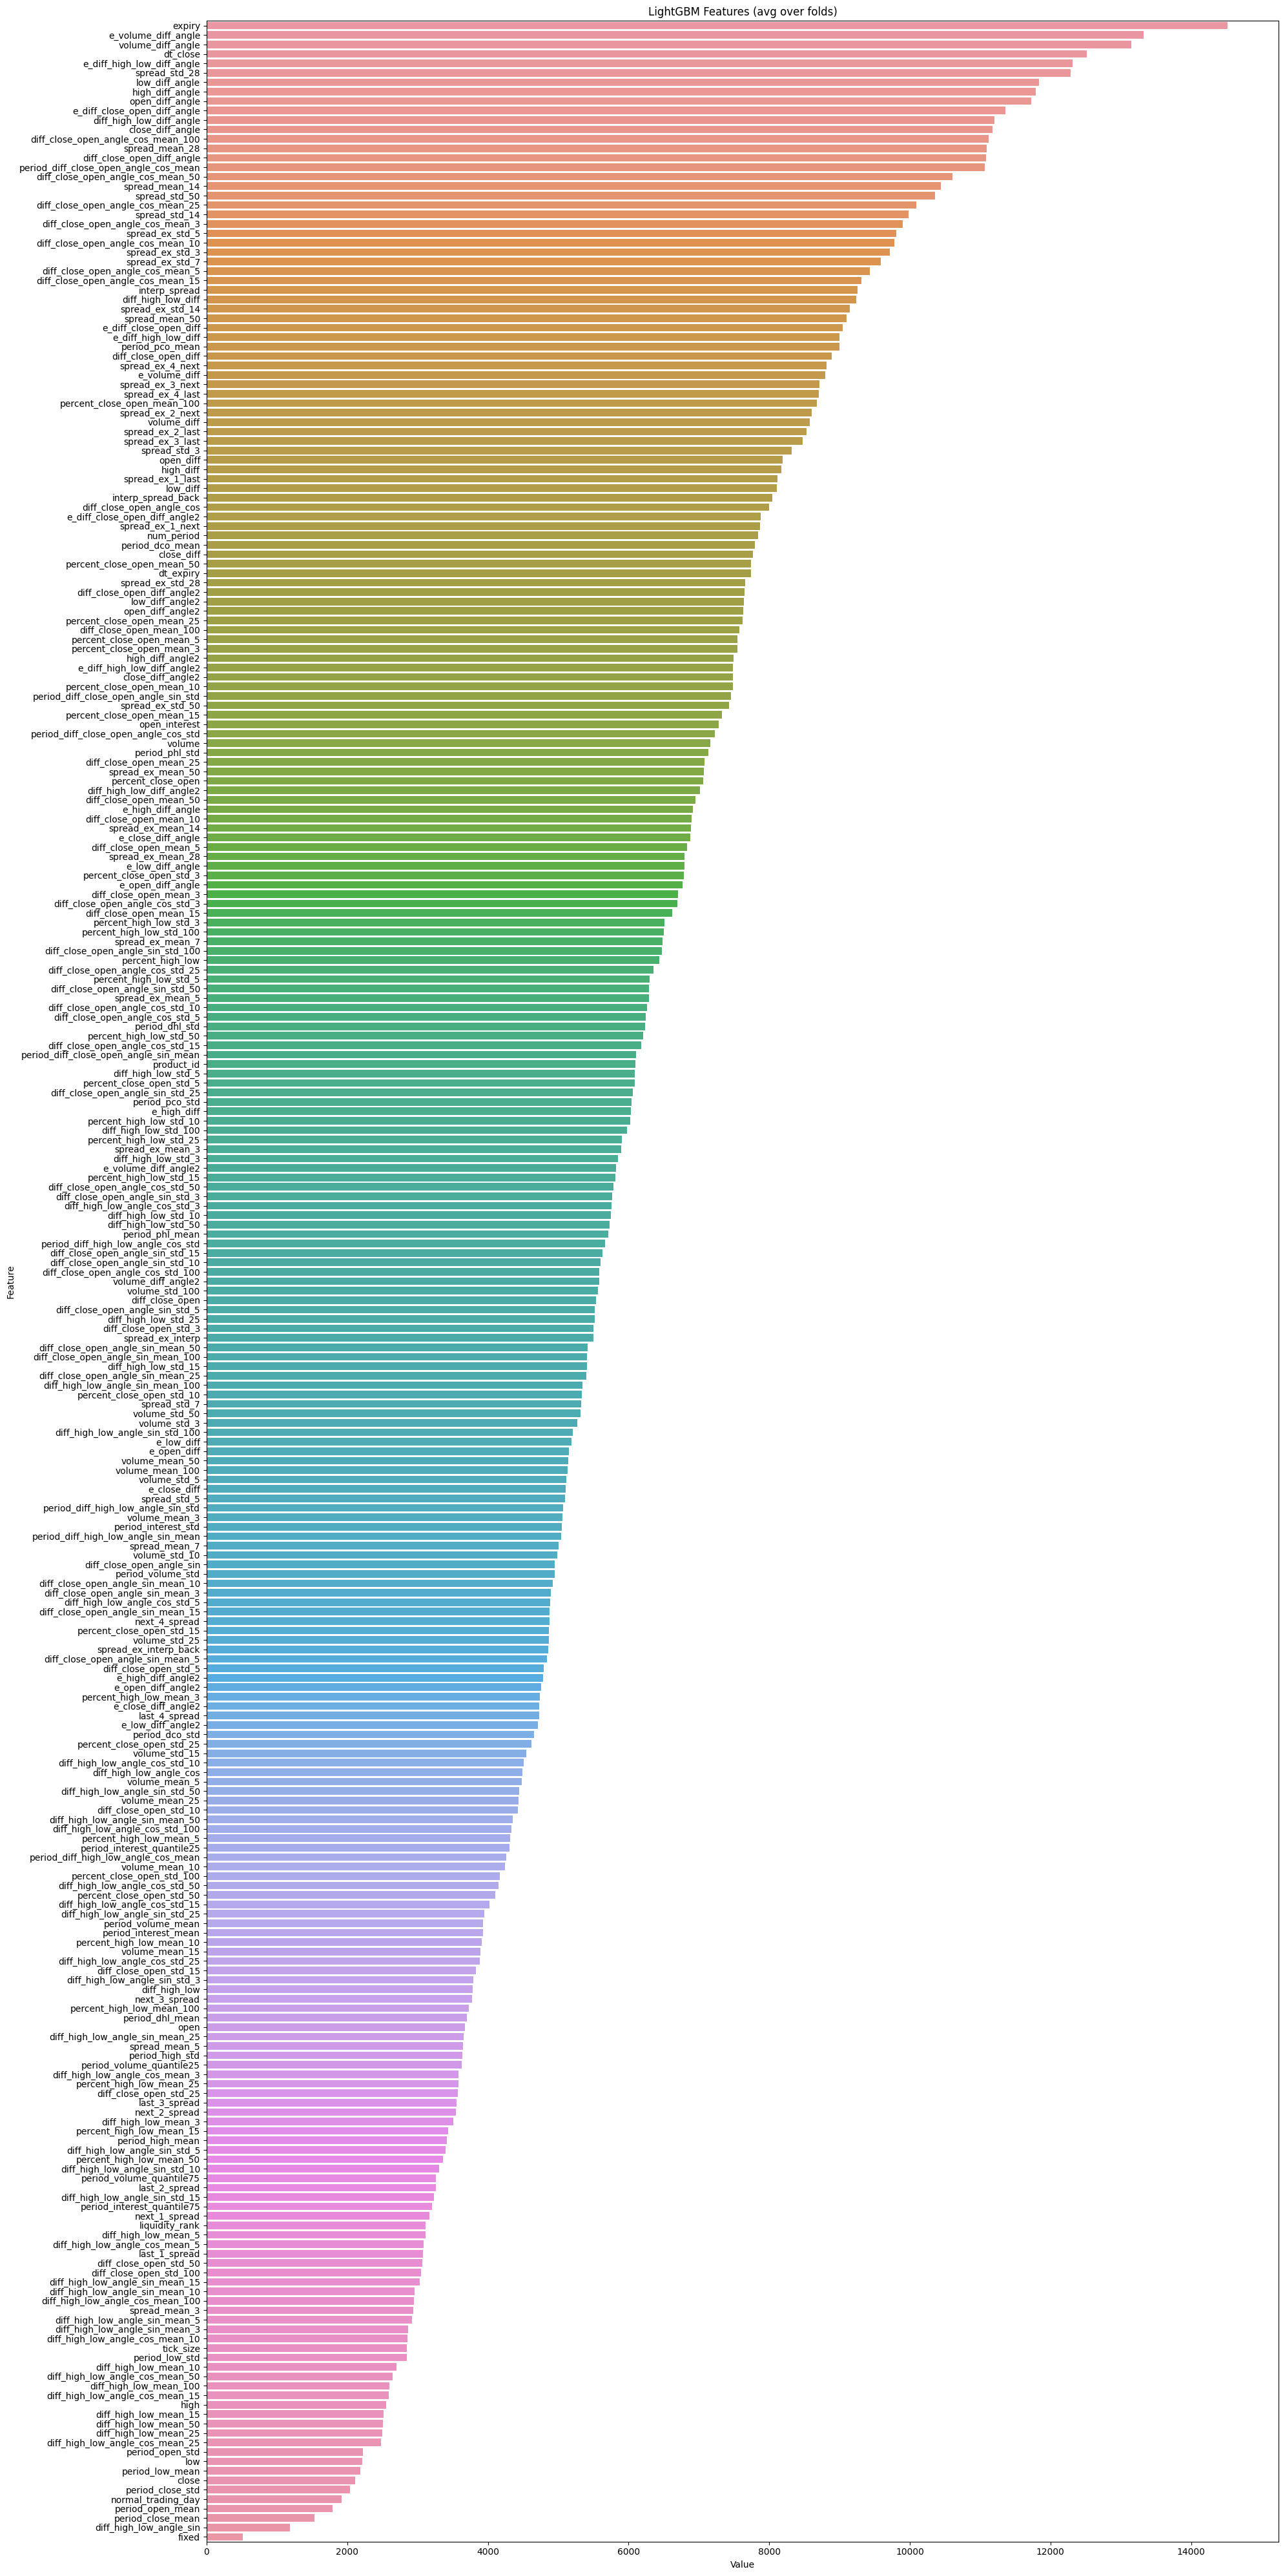

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model_all.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [131]:
df_test_all = pd.read_pickle("df_test_mask_pid5.pkl")
df_test_all_c = df_test_all[cols_conserved].merge(df_all_with_target_fe,on="ID",how="left")
features = df_test_all_c.columns.drop(["ID","spread"])
pred = model_all.predict(df_test_all_c[features])
s_pred = pd.Series(pred,index=df_test_all_c.index,name="spread")
df_pred = pd.concat([s_pred,df_test_all_c["ID"]],axis=1)

sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv").drop("spread",axis=1)
sub_new = sub.merge(df_pred[["ID","spread"]],on="ID")

sub_old = pd.read_csv("submission_mask_pid5_and_submission_mask_pid4_with_fillna_10fold_all_and_1511_0511_clean.csv")

np.mean((sub_new["spread"] - sub_old["spread"]) ** 2)

0.05023654678579438

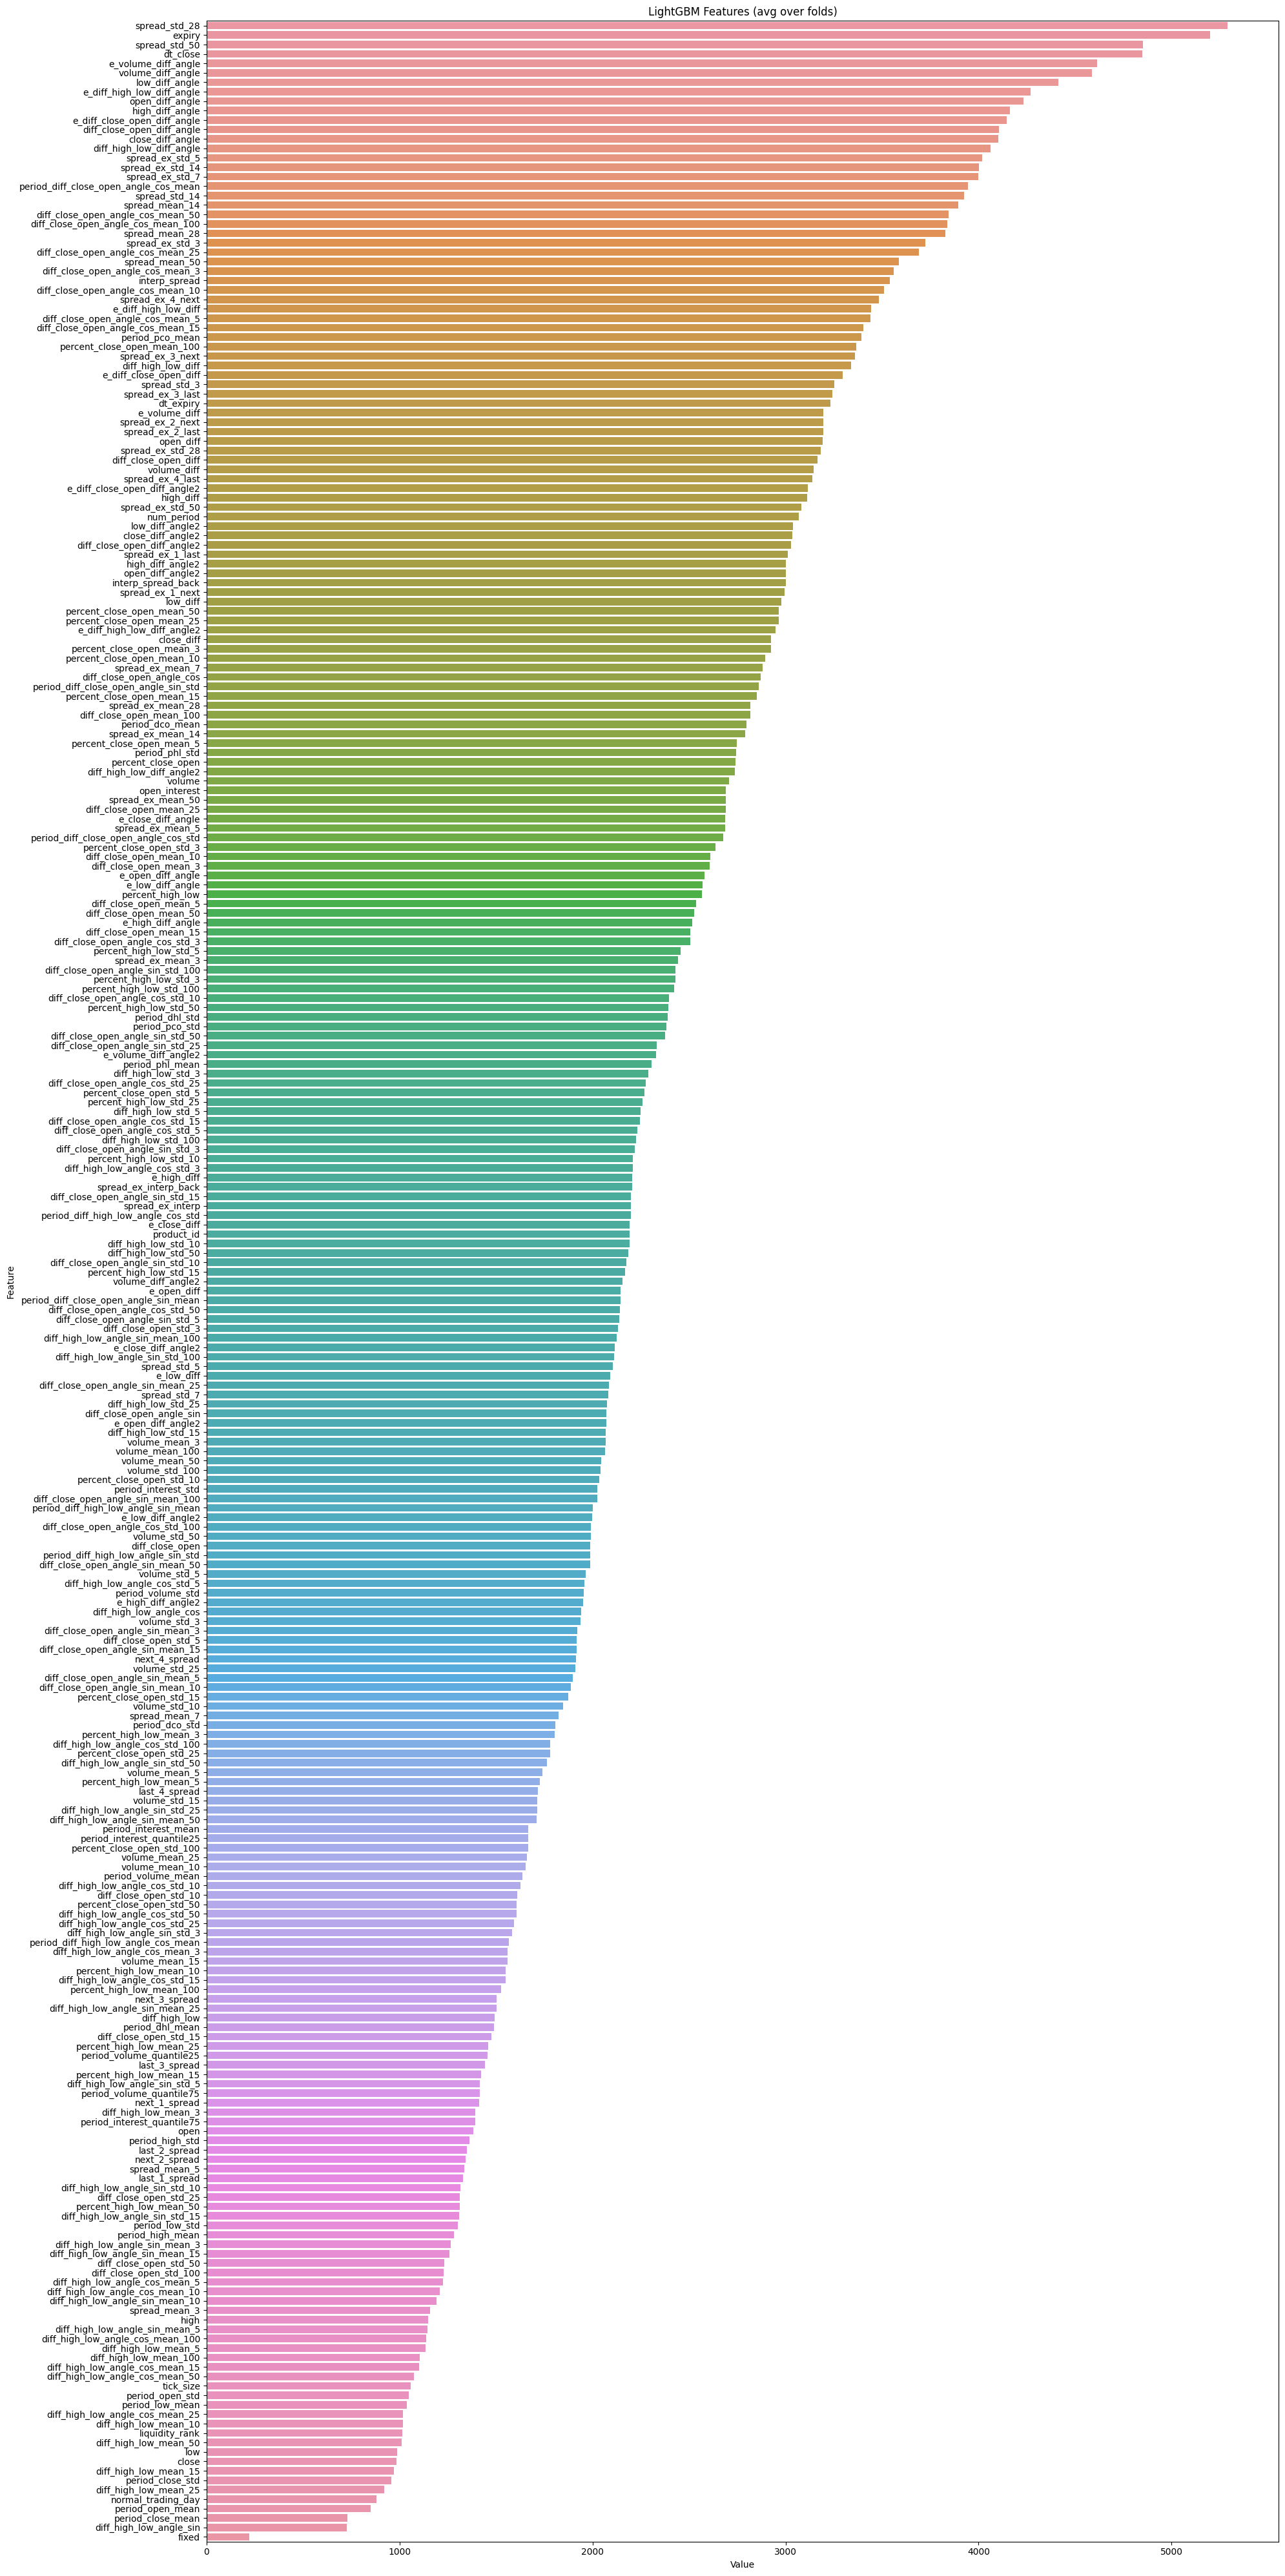

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model_all.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [125]:
df_test_all = pd.read_pickle("df_test_mask_pid5.pkl")
df_test_all_c = df_test_all[cols_conserved].merge(df_all_with_target_fe,on="ID",how="left")
features = df_test_all_c.columns.drop(["ID","spread"])
pred = model_all.predict(df_test_all_c[features])
s_pred = pd.Series(pred,index=df_test_all_c.index,name="spread")
df_pred = pd.concat([s_pred,df_test_all_c["ID"]],axis=1)

sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv").drop("spread",axis=1)
sub_new = sub.merge(df_pred[["ID","spread"]],on="ID")

sub_old = pd.read_csv("submission_mask_pid5_and_submission_mask_pid4_with_fillna_10fold_all_and_1511_0511_clean.csv")

np.mean((sub_new["spread"] - sub_old["spread"]) ** 2)

0.050363973415733274

In [127]:
sub_old

,ID,spread
0,1977,1.558859
1,1978,2.332640
2,1979,2.773326
3,1980,2.975560
4,1981,3.656509
...,...,...
230299,858592,1.042356
230300,858593,1.057847
230301,858594,1.125660
230302,858595,1.104639


In [128]:
sub_new

,ID,spread
0,1977,2.027710
1,1978,2.727502
2,1979,3.084741
3,1980,3.423603
4,1981,3.923255
...,...,...
230299,858592,1.045539
230300,858593,1.050050
230301,858594,1.086191
230302,858595,1.071829


In [126]:
np.sqrt(np.mean((sub_new["spread"] - sub_old["spread"]) ** 2))

0.22441919128214788

In [14]:
xx = df_all_with_target_fe[(df_all_with_target_fe.product_id==401920) & (df_all_with_target_fe.liquidity_rank==2)].sort_values("dt_close")

In [80]:
df_all_with_target_fe_train = df_all_with_target_fe[df_all_with_target_fe["spread"].notnull()]

In [82]:
# with old features
features = df_all_with_target_fe_train.columns.drop(["ID","spread"])
params = {'learning_rate': 0.1, 'num_leaves': 256, 'max_depth': 8,"min_data_in_leaf":50,
    'subsample': 0.8, 
    'colsample_bytree': 0.6 ,'objective': 'regression','metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

id_ti, id_vi = train_test_split(df_all_with_target_fe_train["ID"].unique(),test_size=0.2)

train_idx = df_all_with_target_fe_train[df_all_with_target_fe_train["ID"].isin(id_ti)].index
valid_idx = df_all_with_target_fe_train[df_all_with_target_fe_train["ID"].isin(id_vi)].index
        

import lightgbm as lgb
train_dataset = lgb.Dataset(df_all_with_target_fe_train.loc[train_idx, features],
                            df_all_with_target_fe_train.loc[train_idx, "spread"].values, 
                            #feature_name = features, 
                           )
val_dataset = lgb.Dataset(df_all_with_target_fe_train.loc[valid_idx, features], 
                          df_all_with_target_fe_train.loc[valid_idx, "spread"].values, 
                          #feature_name = features, 
                         )

model_all = lgb.train(params = params,
                  train_set = train_dataset, 
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round = 15000,
                  verbose_eval = 100,    
                  categorical_feature=["fixed","normal_trading_day",]
                 )

/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict 

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.735994	vl's rmse: 0.793246
[200]	tr's rmse: 0.668529	vl's rmse: 0.756105
[300]	tr's rmse: 0.623945	vl's rmse: 0.737153
[400]	tr's rmse: 0.593485	vl's rmse: 0.727836
[500]	tr's rmse: 0.568313	vl's rmse: 0.721672
[600]	tr's rmse: 0.545288	vl's rmse: 0.716501
[700]	tr's rmse: 0.525877	vl's rmse: 0.712916
[800]	tr's rmse: 0.507211	vl's rmse: 0.709533
[900]	tr's rmse: 0.489307	vl's rmse: 0.707348
[1000]	tr's rmse: 0.474159	vl's rmse: 0.705657
[1100]	tr's rmse: 0.459392	vl's rmse: 0.703893
[1200]	tr's rmse: 0.444141	vl's rmse: 0.702557
[1300]	tr's rmse: 0.431388	vl's rmse: 0.701572
[1400]	tr's rmse: 0.419135	vl's rmse: 0.700557
[1500]	tr's rmse: 0.407232	vl's rmse: 0.699824
[1600]	tr's rmse: 0.396233	vl's rmse: 0.699269
[1700]	tr's rmse: 0.384387	vl's rmse: 0.698547
[1800]	tr's rmse: 0.373716	vl's rmse: 0.698229
[1900]	tr's rmse: 0.364902	vl's rmse: 0.697761
[2000]	tr's rmse: 0.35462	vl's rmse: 0.697202
[2100]	tr

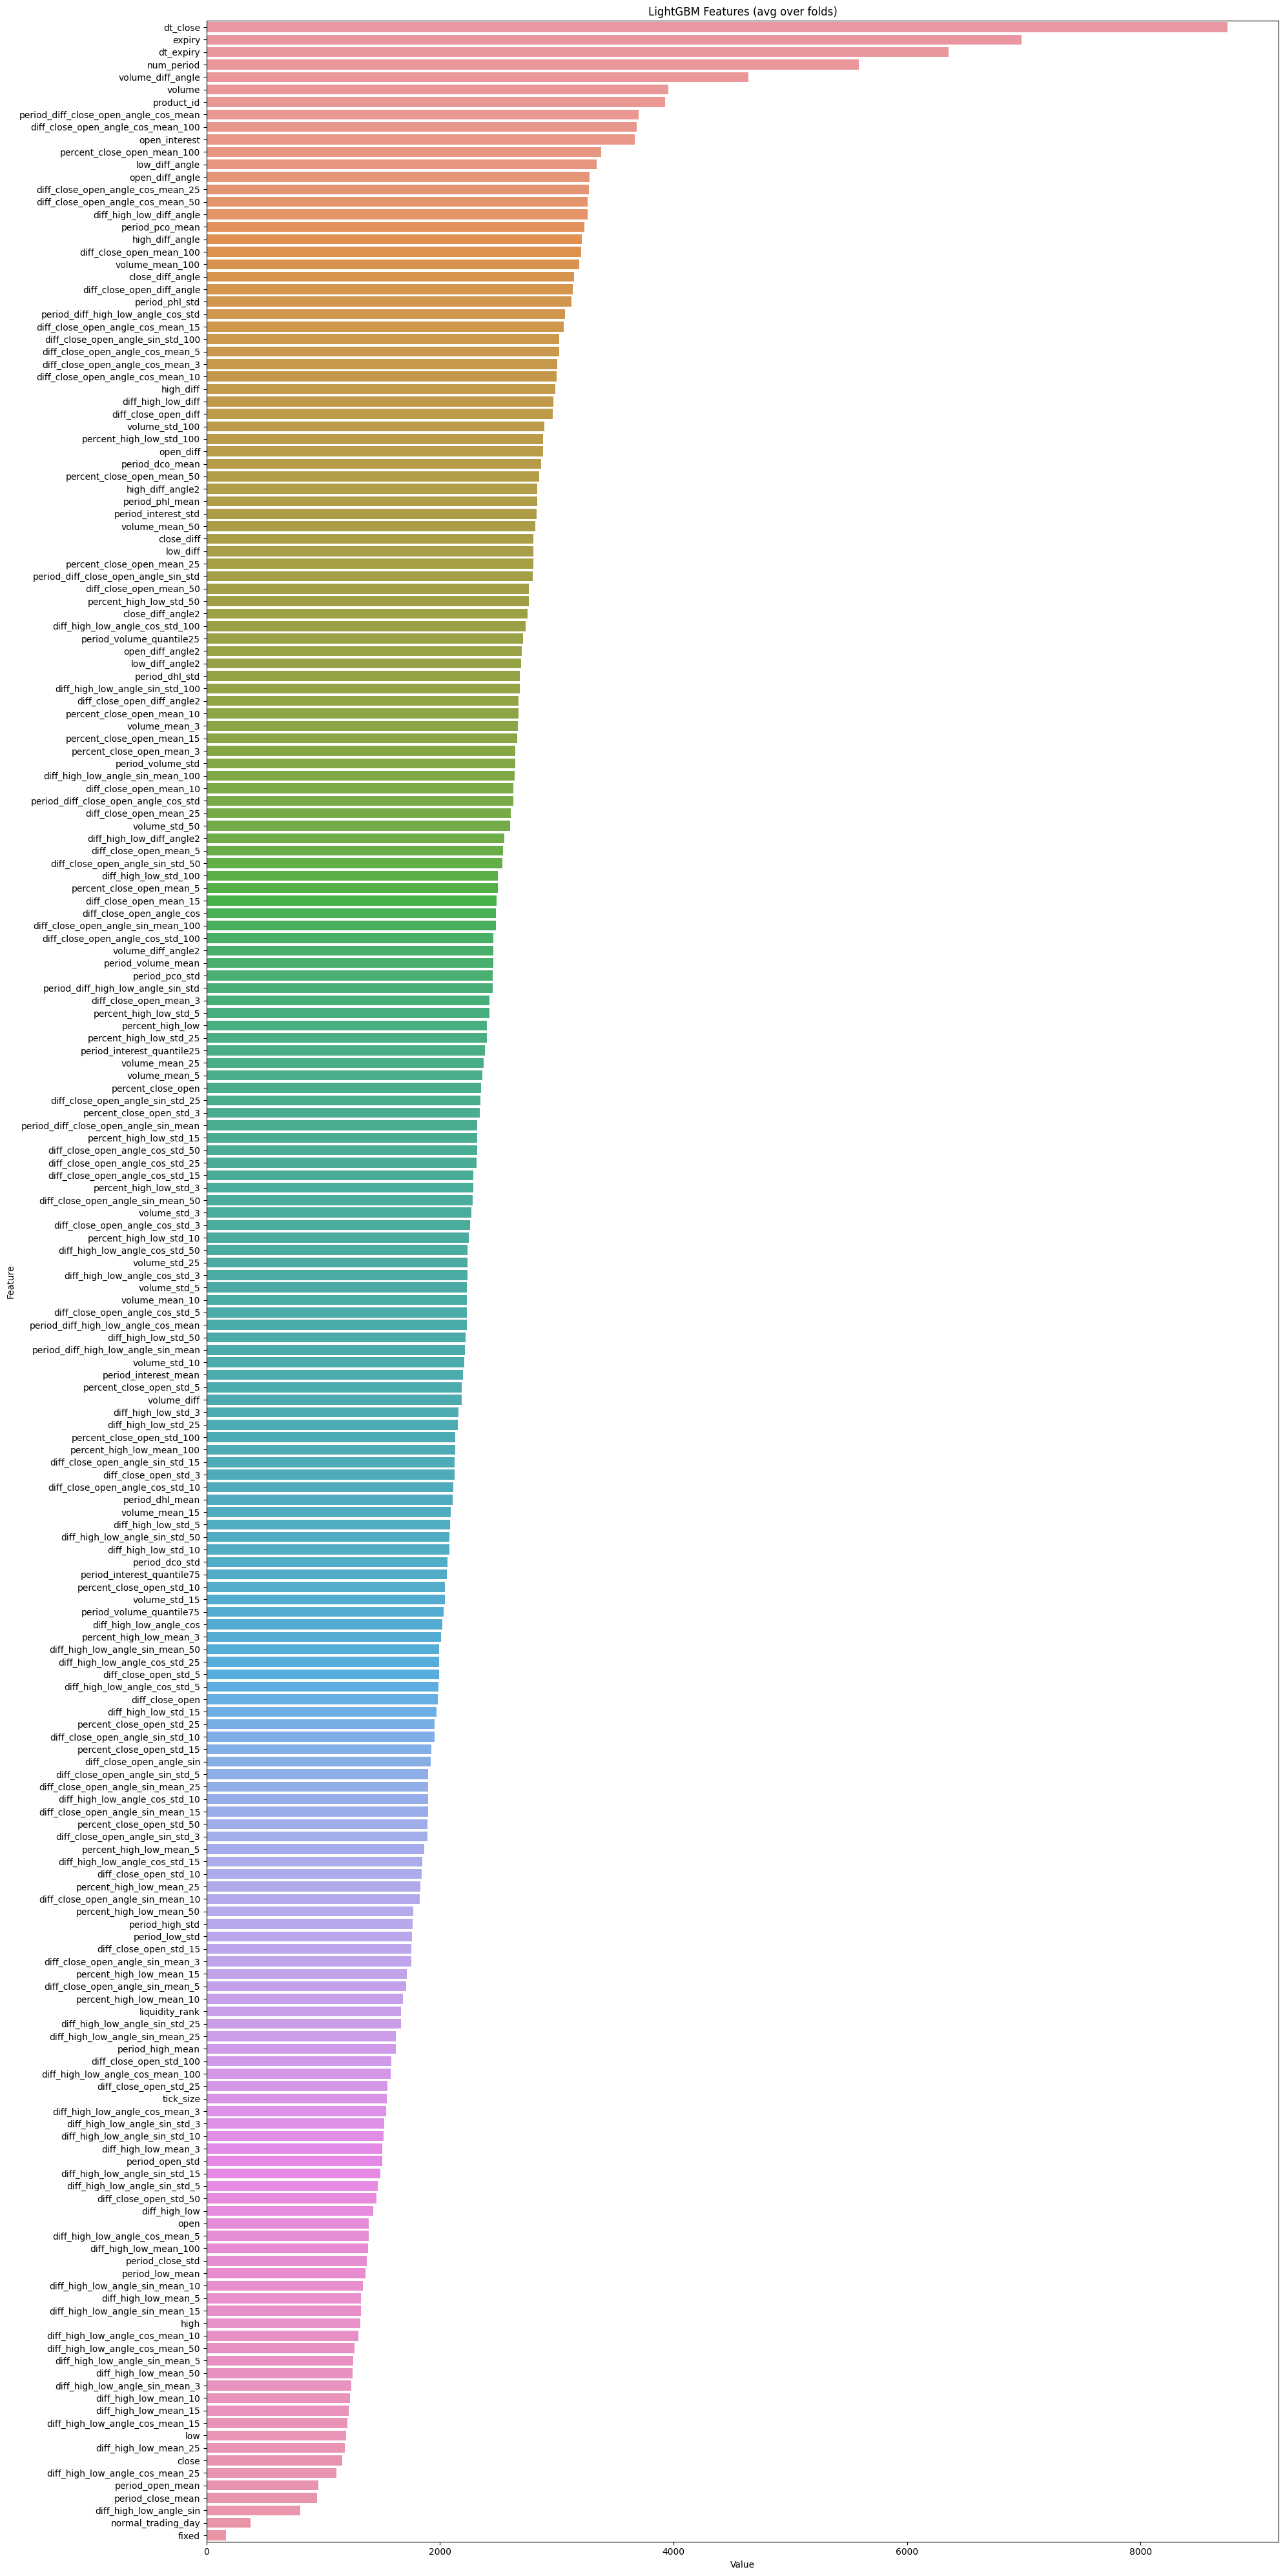

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model_all.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [84]:
df_test_all = df_all_with_target_fe[df_all_with_target_fe["spread"].isnull()]

In [85]:
features = df_test_all.columns.drop(["ID","spread"])

In [86]:
pred = model_all.predict(df_test_all[features])

In [87]:
s_pred = pd.Series(pred,index=df_test_all.index,name="spread")
df_pred = pd.concat([s_pred,df_test_all["ID"]],axis=1)

In [88]:
sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv").drop("spread",axis=1)
sub_new = sub.merge(df_pred[["ID","spread"]],on="ID")

In [89]:
sub_new

,ID,spread
0,1977,1.829066
1,1978,2.322320
2,1979,3.010386
3,1980,3.183607
4,1981,3.615380
...,...,...
230299,858592,1.039392
230300,858593,0.983285
230301,858594,1.081287
230302,858595,1.117782


In [90]:
sub_old = pd.read_csv("submission_mask_pid5_and_submission_mask_pid4_with_fillna_10fold_all_and_1511_0511_clean.csv")

In [91]:
sub_old

,ID,spread
0,1977,1.558859
1,1978,2.332640
2,1979,2.773326
3,1980,2.975560
4,1981,3.656509
...,...,...
230299,858592,1.042356
230300,858593,1.057847
230301,858594,1.125660
230302,858595,1.104639


In [92]:
np.mean((sub_new["spread"] - sub_old["spread"]) ** 2)

0.11797538661177395